In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install hmmlearn
! pip install pyswarms

In [ ]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import MultinomialHMM
import pyswarms as ps
import warnings
import time
import matplotlib.pyplot as plt


# Tắt cảnh báo từ hmmlearn

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning, module="hmmlearn")

In [ ]:
data= pd.read_csv('/content/drive/MyDrive/T1.csv').iloc[:5000]
print("Thông tin tập dữ liệu:")
data.info()
print("\nMột vài dòng đầu tiên:")
print(data.head())

Thông tin tập dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      5000 non-null   object 
 1   LV ActivePower (kW)            5000 non-null   float64
 2   Wind Speed (m/s)               5000 non-null   float64
 3   Theoretical_Power_Curve (KWh)  5000 non-null   float64
 4   Wind Direction (°)             5000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 195.4+ KB

Một vài dòng đầu tiên:
          Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0  01 01 2018 00:00           380.047791          5.311336   
1  01 01 2018 00:10           453.769196          5.672167   
2  01 01 2018 00:20           306.376587          5.216037   
3  01 01 2018 00:30           419.645905          5.659674   
4  01 01 2018 00:40           380.650696          5.577941   



# Đổi tên cột để dễ xử lý (loại bỏ khoảng trắng và ký tự đặc biệt)

In [ ]:
data.columns = ['Date_Time', 'LV_ActivePower_kW', 'Wind_Speed_ms', 'Theoretical_Power_Curve_KWh', 'Wind_Direction_deg']

# Tính phần trăm thay đổi của công suất LV ActivePower (kW)

In [ ]:
data['Power_Change'] = data['LV_ActivePower_kW'].pct_change()

# Rời rạc hóa thay đổi thành các trạng thái: 1 (tăng), -1 (giảm), 0 (không đổi)

In [ ]:
def discretize_change(x):
    if pd.isna(x):
        return 0  # Xử lý giá trị NaN (ví dụ: dòng đầu tiên)
    threshold = 0.0001  # Ngưỡng nhỏ để xác định "không đổi"
    if x > threshold:
        return 1
    elif x < -threshold:
        return -1
    else:
        return 0

data['Observation'] = data['Power_Change'].apply(discretize_change)

# Kiểm tra dữ liệu đã xử lý

In [ ]:
print("\nDữ liệu với các quan sát:")
print(data[['Date_Time', 'LV_ActivePower_kW', 'Power_Change', 'Observation']].head())


Dữ liệu với các quan sát:
          Date_Time  LV_ActivePower_kW  Power_Change  Observation
0  01 01 2018 00:00         380.047791           NaN            0
1  01 01 2018 00:10         453.769196      0.193979            1
2  01 01 2018 00:20         306.376587     -0.324818           -1
3  01 01 2018 00:30         419.645905      0.369706            1
4  01 01 2018 00:40         380.650696     -0.092924           -1


# Loại bỏ các dòng có NaN trong cột 'Observation' (nếu có)

In [ ]:
data = data.dropna(subset=['Observation'])

# Chuẩn bị quan sát cho HMM


In [ ]:
observations = data['Observation'].values.reshape(-1, 1) + 1
observations = observations.astype(np.int32)

# Chuyển thành số lần xuất hiện

In [ ]:
n_samples = len(observations)
n_observations = 3
observation_counts = np.zeros((n_samples, n_observations), dtype=np.int32)
for i, obs in enumerate(observations.flatten()):
    observation_counts[i, obs] = 1

print("\nPhân phối quan sát:", np.sum(observation_counts, axis=0))



Phân phối quan sát: [1697 1646 1657]


# Kiểm tra đa dạng

In [ ]:
if len(np.unique(observations)) < 2:
    print("Lỗi: Dữ liệu quan sát chỉ chứa một giá trị duy nhất. Điều chỉnh ngưỡng!")
    raise ValueError("Dữ liệu không đủ đa dạng.")

# Huấn luyện HMM với EM

In [ ]:
model_em = MultinomialHMM(n_components=3, n_iter=1000, tol=1e-4, random_state=42, n_trials=1)
start_time_em = time.time()
model_em.fit(observation_counts)
time_em = time.time() - start_time_em
print(f"Thời gian huấn luyện EM: {time_em:.2f} giây")

2025-05-13 10:50:51,163 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Thời gian huấn luyện EM: 2.91 giây


# Dự đoán trạng thái ẩn với EM

In [ ]:
hidden_states_em = model_em.predict(observation_counts)
data['Hidden_State_EM'] = hidden_states_em
print("\nDữ liệu với trạng thái ẩn (EM):")
print(data[['Date_Time', 'LV_ActivePower_kW', 'Observation', 'Hidden_State_EM']].head())


Dữ liệu với trạng thái ẩn (EM):
          Date_Time  LV_ActivePower_kW  Observation  Hidden_State_EM
0  01 01 2018 00:00         380.047791            0                2
1  01 01 2018 00:10         453.769196            1                0
2  01 01 2018 00:20         306.376587           -1                1
3  01 01 2018 00:30         419.645905            1                0
4  01 01 2018 00:40         380.650696           -1                1



# Hàm fitness cho PSO

In [ ]:
def fitness_function(params, observations):
    n_components = 3
    n_observations = 3
    fitness = []
    for i, param in enumerate(params):
        try:
            A = np.reshape(param[:9], (n_components, n_components))
            B = np.reshape(param[9:18], (n_components, n_observations))
            pi = param[18:]

            A_sum = np.sum(np.maximum(A, 0), axis=1, keepdims=True)
            B_sum = np.sum(np.maximum(B, 0), axis=1, keepdims=True)
            pi_sum = np.sum(np.maximum(pi, 0))

            if np.any(A_sum < 1e-10) or np.any(B_sum < 1e-10) or pi_sum < 1e-10:
                print(f"Hạt {i}: Tổng ma trận bằng 0")
                fitness.append(np.inf)
                continue

            A = np.maximum(A, 0) / (A_sum + 1e-10)
            B = np.maximum(B, 0) / (B_sum + 1e-10)
            pi = np.maximum(pi, 0) / (pi_sum + 1e-10)

            model = MultinomialHMM(n_components=n_components, init_params="", n_trials=1)
            model.startprob_ = pi
            model.transmat_ = A
            model.emissionprob_ = B

            start_time = time.time()
            log_likelihood = model.score(observations)
            print(f"Hạt {i}: Thời gian tính log-likelihood: {time.time() - start_time:.2f} giây")
            if np.isnan(log_likelihood) or np.isinf(log_likelihood):
                print(f"Hạt {i}: Log-likelihood không hợp lệ")
                fitness.append(np.inf)
            else:
                fitness.append(-log_likelihood)
        except Exception as e:
            print(f"Hạt {i}: Lỗi: {e}")
            fitness.append(np.inf)
    return np.array(fitness)

# Cài đặt PSO

In [ ]:
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
n_particles = 10
dimensions = 9 + 9 + 3

bounds = (np.zeros(dimensions), np.ones(dimensions))
init_pos = np.random.uniform(0.1, 0.9, size=(n_particles, dimensions))

optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=options, bounds=bounds, init_pos=init_pos)

# Tối ưu bằng PSO

In [ ]:
try:
    start_time_pso = time.time()
    best_cost, best_pos = optimizer.optimize(lambda x: fitness_function(x, observation_counts), iters=50)
    time_pso = time.time() - start_time_pso
    # Sử dụng len(cost_history) để lấy số lần lặp thực tế
    num_iterations = len(optimizer.cost_history)
    print(f"Thời gian tối ưu PSO: {time_pso:.2f} giây")
    print(f"Số lần hội tụ (iterations): {num_iterations}")
except Exception as e:
    print(f"Lỗi PSO: {e}")
    raise

2025-05-13 10:50:54,189 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/502025-05-13 10:50:54,195 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:54,205 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues f

Hạt 0: Thời gian tính log-likelihood: 0.01 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:54,289 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Hạt 6: Thời gian tính log-likelihood: 0.02 giây


2025-05-13 10:50:54,307 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:54,321 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=5.5

Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.01 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:54,415 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:54,431 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:54,438 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 4: Thời gian tính log-likelihood: 0.04 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây
Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.01 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:54,491 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:54,498 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:54,504 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:54,515 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:54,524 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:54,531 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 6: Thời gian tính log-likelihood: 0.01 giây
Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.00 giây
Hạt 1: Thời gian tính log-likelihood: 0.00 giây
Hạt 2: Thời gian tính log-likelihood: 0.00 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây
Hạt 7: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:54,618 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=5.4e+32025-05-13 10:50:54,635 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/3

Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.01 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:54,698 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:54,708 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:54,721 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:54,733 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
pyswarms.single.global_best:  10%|█         |5/50, best_cost=5.4

Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.01 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây
Hạt 7: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:54,827 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=5.4e+32025-05-13 10:50:54,846 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/3

Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.01 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:54,902 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:54,915 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:54,933 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:54,945 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:54,954 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 6: Thời gian tính log-likelihood: 0.01 giây
Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.01 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:55,027 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:55,035 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:55,042 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.00 giây
Hạt 0: Thời gian tính log-likelihood: 0.00 giây
Hạt 1: Thời gian tính log-likelihood: 0.00 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.00 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:55,107 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:55,113 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
pyswarms.single.global_best:  18%|█▊        |9/50, best_cost=5.3

Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.00 giây


2025-05-13 10:50:55,139 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:55,148 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:55,156 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.00 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.00 giây
Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.00 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.01 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:55,239 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:55,246 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:55,255 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.00 giây
Hạt 7: Thời gian tính log-likelihood: 0.00 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.01 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:55,315 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:55,330 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:55,343 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:55,355 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:55,380 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.02 giây
Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:55,446 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:55,462 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:55,479 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:55,525 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:55,541 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Hạt 6: Thời gian tính log-likelihood: 0.01 giây
Hạt 7: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:55,552 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
pyswarms.single.global_best:  26%|██▌       |13/50, best_cost=4.75e+32025-05-13 10:50:55,564 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues

Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.01 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.02 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:55,656 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:55,672 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:55,686 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây
Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:55,728 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:55,737 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:55,745 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 0: Thời gian tính log-likelihood: 0.01 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:55,757 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:55,772 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:55,782 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây
Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:55,869 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:55,885 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:55,900 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.02 giây


2025-05-13 10:50:55,941 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:55,952 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:55,969 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:55,978 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.01 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:56,072 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:56,083 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
pyswarms.single.global_best:  34%|███▍      |17/50, best_cost=4.

Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.01 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:56,150 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:56,163 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:56,176 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:56,186 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:56,199 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 6: Thời gian tính log-likelihood: 0.01 giây
Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.01 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:56,277 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:56,303 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:56,337 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.02 giây


2025-05-13 10:50:56,360 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Hạt 7: Thời gian tính log-likelihood: 0.02 giây


2025-05-13 10:50:56,386 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
pyswarms.single.global_best:  38%|███▊      |19/50, best_cost=4.75e+32025-05-13 10:50:56,418 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues

Hạt 8: Thời gian tính log-likelihood: 0.02 giây
Hạt 9: Thời gian tính log-likelihood: 0.02 giây
Hạt 0: Thời gian tính log-likelihood: 0.02 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:56,499 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:56,526 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:56,546 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 3: Thời gian tính log-likelihood: 0.02 giây
Hạt 4: Thời gian tính log-likelihood: 0.02 giây
Hạt 5: Thời gian tính log-likelihood: 0.02 giây


2025-05-13 10:50:56,584 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Hạt 6: Thời gian tính log-likelihood: 0.03 giây


2025-05-13 10:50:56,620 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:56,687 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Hạt 7: Thời gian tính log-likelihood: 0.03 giây
Hạt 8: Thời gian tính log-likelihood: 0.03 giây


pyswarms.single.global_best:  40%|████      |20/50, best_cost=4.75e+32025-05-13 10:50:56,723 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:56,742 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues

Hạt 9: Thời gian tính log-likelihood: 0.03 giây
Hạt 0: Thời gian tính log-likelihood: 0.02 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:56,804 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Hạt 3: Thời gian tính log-likelihood: 0.03 giây


2025-05-13 10:50:56,830 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:56,839 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:56,850 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 4: Thời gian tính log-likelihood: 0.02 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây
Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.02 giây
Hạt 0: Thời gian tính log-likelihood: 0.02 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:56,927 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:56,935 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:56,945 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.02 giây
Hạt 6: Thời gian tính log-likelihood: 0.02 giây


2025-05-13 10:50:57,018 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Hạt 7: Thời gian tính log-likelihood: 0.02 giây


2025-05-13 10:50:57,048 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
pyswarms.single.global_best:  44%|████▍     |22/50, best_cost=4.75e+32025-05-13 10:50:57,067 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues

Hạt 8: Thời gian tính log-likelihood: 0.02 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.01 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:57,130 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:57,149 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:57,168 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 2: Thời gian tính log-likelihood: 0.02 giây
Hạt 3: Thời gian tính log-likelihood: 0.02 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:57,224 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Hạt 7: Thời gian tính log-likelihood: 0.02 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:57,240 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
pyswarms.single.global_best:  46%|████▌     |23/50, best_cost=4.75e+32025-05-13 10:50:57,270 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues

Hạt 9: Thời gian tính log-likelihood: 0.02 giây
Hạt 0: Thời gian tính log-likelihood: 0.01 giây
Hạt 1: Thời gian tính log-likelihood: 0.02 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:57,328 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:57,352 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:57,374 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 3: Thời gian tính log-likelihood: 0.02 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.02 giây
Hạt 6: Thời gian tính log-likelihood: 0.02 giây


2025-05-13 10:50:57,442 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Hạt 7: Thời gian tính log-likelihood: 0.02 giây
Hạt 8: Thời gian tính log-likelihood: 0.02 giây


2025-05-13 10:50:57,461 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
pyswarms.single.global_best:  48%|████▊     |24/50, best_cost=4.75e+32025-05-13 10:50:57,493 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues

Hạt 9: Thời gian tính log-likelihood: 0.02 giây
Hạt 0: Thời gian tính log-likelihood: 0.02 giây
Hạt 1: Thời gian tính log-likelihood: 0.02 giây


2025-05-13 10:50:57,561 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:57,580 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:57,599 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 2: Thời gian tính log-likelihood: 0.02 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.02 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:57,646 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:57,668 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Hạt 6: Thời gian tính log-likelihood: 0.02 giây
Hạt 7: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:57,690 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
pyswarms.single.global_best:  50%|█████     |25/50, best_cost=4.75e+32025-05-13 10:50:57,713 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues

Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.02 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:57,750 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:57,774 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:57,791 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.02 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:57,867 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:57,882 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây


pyswarms.single.global_best:  52%|█████▏    |26/50, best_cost=4.75e+32025-05-13 10:50:57,910 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:57,928 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues

Hạt 9: Thời gian tính log-likelihood: 0.02 giây
Hạt 0: Thời gian tính log-likelihood: 0.02 giây
Hạt 1: Thời gian tính log-likelihood: 0.02 giây
Hạt 2: Thời gian tính log-likelihood: 0.02 giây


2025-05-13 10:50:57,984 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:58,001 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:58,018 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 3: Thời gian tính log-likelihood: 0.02 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây
Hạt 7: Thời gian tính log-likelihood: 0.02 giây


2025-05-13 10:50:58,085 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Hạt 8: Thời gian tính log-likelihood: 0.02 giây


pyswarms.single.global_best:  54%|█████▍    |27/50, best_cost=4.75e+32025-05-13 10:50:58,109 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:58,128 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues

Hạt 9: Thời gian tính log-likelihood: 0.02 giây
Hạt 0: Thời gian tính log-likelihood: 0.01 giây
Hạt 1: Thời gian tính log-likelihood: 0.02 giây
Hạt 2: Thời gian tính log-likelihood: 0.03 giây


2025-05-13 10:50:58,204 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:58,247 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:58,274 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 3: Thời gian tính log-likelihood: 0.02 giây
Hạt 4: Thời gian tính log-likelihood: 0.04 giây
Hạt 5: Thời gian tính log-likelihood: 0.02 giây


2025-05-13 10:50:58,300 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Hạt 6: Thời gian tính log-likelihood: 0.02 giây


2025-05-13 10:50:58,324 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:58,345 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
pyswarms.single.global_best:  54%|█████▍    |27/50, best_cost=4.

Hạt 7: Thời gian tính log-likelihood: 0.02 giây
Hạt 8: Thời gian tính log-likelihood: 0.02 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây


pyswarms.single.global_best:  56%|█████▌    |28/50, best_cost=4.75e+32025-05-13 10:50:58,415 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:58,448 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues

Hạt 0: Thời gian tính log-likelihood: 0.03 giây
Hạt 1: Thời gian tính log-likelihood: 0.02 giây
Hạt 2: Thời gian tính log-likelihood: 0.02 giây


2025-05-13 10:50:58,549 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:58,565 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:58,611 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 3: Thời gian tính log-likelihood: 0.05 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.04 giây
Hạt 6: Thời gian tính log-likelihood: 0.03 giây


2025-05-13 10:50:58,644 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:58,698 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:58,723 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 7: Thời gian tính log-likelihood: 0.03 giây
Hạt 8: Thời gian tính log-likelihood: 0.02 giây


pyswarms.single.global_best:  58%|█████▊    |29/50, best_cost=4.75e+32025-05-13 10:50:58,764 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:58,792 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues

Hạt 9: Thời gian tính log-likelihood: 0.02 giây
Hạt 0: Thời gian tính log-likelihood: 0.03 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.02 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:58,912 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:58,931 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Hạt 7: Thời gian tính log-likelihood: 0.02 giây
Hạt 8: Thời gian tính log-likelihood: 0.02 giây


pyswarms.single.global_best:  60%|██████    |30/50, best_cost=4.75e+32025-05-13 10:50:58,959 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:58,978 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues

Hạt 9: Thời gian tính log-likelihood: 0.02 giây
Hạt 0: Thời gian tính log-likelihood: 0.02 giây
Hạt 1: Thời gian tính log-likelihood: 0.03 giây
Hạt 2: Thời gian tính log-likelihood: 0.04 giây
Hạt 3: Thời gian tính log-likelihood: 0.04 giây
Hạt 4: Thời gian tính log-likelihood: 0.03 giây

2025-05-13 10:50:59,157 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:59,181 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:59,194 - hmmlearn.hmm - WARNING - MultinomialHM


Hạt 5: Thời gian tính log-likelihood: 0.02 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây
Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.03 giây
Hạt 1: Thời gian tính log-likelihood: 0.02 giây
Hạt 2: Thời gian tính log-likelihood: 0.03 giây


2025-05-13 10:50:59,331 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:59,384 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:59,397 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 3: Thời gian tính log-likelihood: 0.03 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.03 giây
Hạt 7: Thời gian tính log-likelihood: 0.04 giây
Hạt 8: Thời gian tính log-likelihood: 0.03 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:59,592 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:59,605 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:59,621 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây
Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.02 giây
Hạt 1: Thời gian tính log-likelihood: 0.02 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:50:59,792 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:59,812 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:50:59,854 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.03 giây
Hạt 6: Thời gian tính log-likelihood: 0.03 giây
Hạt 7: Thời gian tính log-likelihood: 0.02 giây
Hạt 8: Thời gian tính log-likelihood: 0.02 giây
Hạt 9: Thời gian tính log-likelihood: 0.03 giây
Hạt 0: Thời gian tính log-likelihood: 0.01 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:51:00,009 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:00,028 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:00,043 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.02 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây
Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.02 giây
Hạt 1: Thời gian tính log-likelihood: 0.02 giây
Hạt 2: Thời gian tính log-likelihood: 0.03 giây
Hạt 3: Thời gian tính log-likelihood: 0.02 giây


2025-05-13 10:51:00,248 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:00,269 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:00,293 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 4: Thời gian tính log-likelihood: 0.02 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.02 giây
Hạt 7: Thời gian tính log-likelihood: 0.03 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.02 giây
Hạt 1: Thời gian tính log-likelihood: 0.02 giây


2025-05-13 10:51:00,459 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:00,470 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:00,520 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.04 giây
Hạt 5: Thời gian tính log-likelihood: 0.04 giây
Hạt 6: Thời gian tính log-likelihood: 0.03 giây
Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.03 giây


pyswarms.single.global_best:  74%|███████▍  |37/50, best_cost=4.68e+32025-05-13 10:51:00,668 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:00,685 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues

Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.01 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.02 giây
Hạt 3: Thời gian tính log-likelihood: 0.04 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây
Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.02 giây


pyswarms.single.global_best:  76%|███████▌  |38/50, best_cost=4.68e+32025-05-13 10:51:00,878 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:00,900 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues

Hạt 9: Thời gian tính log-likelihood: 0.02 giây
Hạt 0: Thời gian tính log-likelihood: 0.02 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.02 giây
Hạt 4: Thời gian tính log-likelihood: 0.04 giây
Hạt 5: Thời gian tính log-likelihood: 0.03 giây
Hạt 6: Thời gian tính log-likelihood: 0.02 giây


2025-05-13 10:51:01,114 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:01,161 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
pyswarms.single.global_best:  78%|███████▊  |39/50, best_cost=4.

Hạt 7: Thời gian tính log-likelihood: 0.02 giây
Hạt 8: Thời gian tính log-likelihood: 0.05 giây
Hạt 9: Thời gian tính log-likelihood: 0.04 giây
Hạt 0: Thời gian tính log-likelihood: 0.02 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:51:01,316 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:01,330 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:01,346 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 6: Thời gian tính log-likelihood: 0.02 giây
Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.02 giây
Hạt 0: Thời gian tính log-likelihood: 0.01 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.02 giây
Hạt 5: Thời gian tính log-likelihood: 0.02 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:51:01,522 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:01,537 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
pyswarms.single.global_best:  82%|████████▏ |41/50, best_cost=4.

Hạt 7: Thời gian tính log-likelihood: 0.02 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.02 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây
Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.02 giây


2025-05-13 10:51:01,721 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:01,736 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:01,755 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 0: Thời gian tính log-likelihood: 0.01 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.02 giây
Hạt 4: Thời gian tính log-likelihood: 0.02 giây
Hạt 5: Thời gian tính log-likelihood: 0.02 giây
Hạt 6: Thời gian tính log-likelihood: 0.02 giây
Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:51:01,952 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:01,970 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:01,987 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 1: Thời gian tính log-likelihood: 0.02 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.02 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây
Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.02 giây
Hạt 1: Thời gian tính log-likelihood: 0.02 giây


2025-05-13 10:51:02,158 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:02,178 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:02,208 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 2: Thời gian tính log-likelihood: 0.02 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.03 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.05 giây
Hạt 7: Thời gian tính log-likelihood: 0.04 giây


2025-05-13 10:51:02,364 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
pyswarms.single.global_best:  90%|█████████ |45/50, best_cost=4.68e+32025-05-13 10:51:02,402 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues

Hạt 8: Thời gian tính log-likelihood: 0.03 giây
Hạt 9: Thời gian tính log-likelihood: 0.02 giây
Hạt 0: Thời gian tính log-likelihood: 0.02 giây
Hạt 1: Thời gian tính log-likelihood: 0.02 giây
Hạt 2: Thời gian tính log-likelihood: 0.04 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:51:02,577 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:02,606 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:02,640 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 5: Thời gian tính log-likelihood: 0.04 giây
Hạt 6: Thời gian tính log-likelihood: 0.02 giây
Hạt 7: Thời gian tính log-likelihood: 0.02 giây
Hạt 8: Thời gian tính log-likelihood: 0.02 giây
Hạt 9: Thời gian tính log-likelihood: 0.02 giây
Hạt 0: Thời gian tính log-likelihood: 0.04 giây


2025-05-13 10:51:02,795 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:02,817 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:02,831 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 1: Thời gian tính log-likelihood: 0.03 giây
Hạt 2: Thời gian tính log-likelihood: 0.02 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.01 giây
Hạt 5: Thời gian tính log-likelihood: 0.02 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây
Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Hạt 0: Thời gian tính log-likelihood: 0.01 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:51:03,008 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:03,030 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:03,074 - hmmlearn.hmm - WARNING - MultinomialHM

Hạt 3: Thời gian tính log-likelihood: 0.02 giây
Hạt 4: Thời gian tính log-likelihood: 0.02 giây
Hạt 5: Thời gian tính log-likelihood: 0.04 giây
Hạt 6: Thời gian tính log-likelihood: 0.07 giây
Hạt 7: Thời gian tính log-likelihood: 0.05 giây


2025-05-13 10:51:03,204 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:03,258 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
pyswarms.single.global_best:  96%|█████████▌|48/50, best_cost=4.

Hạt 8: Thời gian tính log-likelihood: 0.04 giây
Hạt 9: Thời gian tính log-likelihood: 0.02 giây
Hạt 0: Thời gian tính log-likelihood: 0.03 giây
Hạt 1: Thời gian tính log-likelihood: 0.02 giây
Hạt 2: Thời gian tính log-likelihood: 0.01 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.02 giây
Hạt 5: Thời gian tính log-likelihood: 0.02 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:51:03,474 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:03,506 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
pyswarms.single.global_best:  98%|█████████▊|49/50, best_cost=4.

Hạt 7: Thời gian tính log-likelihood: 0.01 giây
Hạt 8: Thời gian tính log-likelihood: 0.02 giây
Hạt 9: Thời gian tính log-likelihood: 0.02 giây
Hạt 0: Thời gian tính log-likelihood: 0.01 giây
Hạt 1: Thời gian tính log-likelihood: 0.01 giây
Hạt 2: Thời gian tính log-likelihood: 0.02 giây
Hạt 3: Thời gian tính log-likelihood: 0.01 giây
Hạt 4: Thời gian tính log-likelihood: 0.03 giây
Hạt 5: Thời gian tính log-likelihood: 0.01 giây
Hạt 6: Thời gian tính log-likelihood: 0.01 giây


2025-05-13 10:51:03,691 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
2025-05-13 10:51:03,702 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=4.

Hạt 7: Thời gian tính log-likelihood: 0.02 giây
Hạt 8: Thời gian tính log-likelihood: 0.01 giây
Hạt 9: Thời gian tính log-likelihood: 0.01 giây
Thời gian tối ưu PSO: 9.54 giây
Số lần hội tụ (iterations): 50


# Kết quả PSO

In [ ]:
print("\nKết quả tối ưu PSO:")
print("Giá trị tốt nhất (negative log-likelihood):", best_cost)
print("Tham số tốt nhất:", best_pos)


Kết quả tối ưu PSO:
Giá trị tốt nhất (negative log-likelihood): 4681.657513061819
Tham số tốt nhất: [0.02284953 0.19738271 0.53373398 0.47283283 0.61833185 0.01552356
 0.81571714 0.18204394 0.64109932 0.44993385 0.29179941 0.51810122
 0.04707885 0.79236726 0.15459469 0.90062992 0.01853027 0.39530589
 0.50509758 0.32206244 0.55936189]


# Đánh giá log-likelihood với EM

In [ ]:
log_likelihood_em = model_em.score(observation_counts)
print("\nLog-likelihood HMM với EM:", log_likelihood_em)


Log-likelihood HMM với EM: -3546.253825559638


# Đánh giá log-likelihood với PSO

In [ ]:
A_best = np.reshape(best_pos[:9], (3, 3))
B_best = np.reshape(best_pos[9:18], (3, 3))
pi_best = best_pos[18:]
A_best = np.maximum(A_best, 0) / (np.sum(np.maximum(A_best, 0), axis=1, keepdims=True) + 1e-10)
B_best = np.maximum(B_best, 0) / (np.sum(np.maximum(B_best, 0), axis=1, keepdims=True) + 1e-10)
pi_best = np.maximum(pi_best, 0) / (np.sum(np.maximum(pi_best, 0)) + 1e-10)

model_pso = MultinomialHMM(n_components=3, init_params="", n_trials=1)
model_pso.startprob_ = pi_best
model_pso.transmat_ = A_best
model_pso.emissionprob_ = B_best
log_likelihood_pso = model_pso.score(observation_counts)
print("Log-likelihood HMM với PSO:", log_likelihood_pso)

2025-05-13 10:51:43,101 - hmmlearn.hmm - WARNING - MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Log-likelihood HMM với PSO: -4681.657513061819


# So sánh kết quả

In [ ]:
print("\nSo sánh:")
if log_likelihood_pso > log_likelihood_em:
    print("Mô hình HMM tối ưu bằng PSO hoạt động tốt hơn mô hình HMM huấn luyện bằng EM.")
else:
    print("Mô hình HMM huấn luyện bằng EM hoạt động tốt hơn hoặc tương đương mô hình HMM tối ưu bằng PSO.")


So sánh:
Mô hình HMM huấn luyện bằng EM hoạt động tốt hơn hoặc tương đương mô hình HMM tối ưu bằng PSO.


# Trực quan hóa trạng thái ẩn

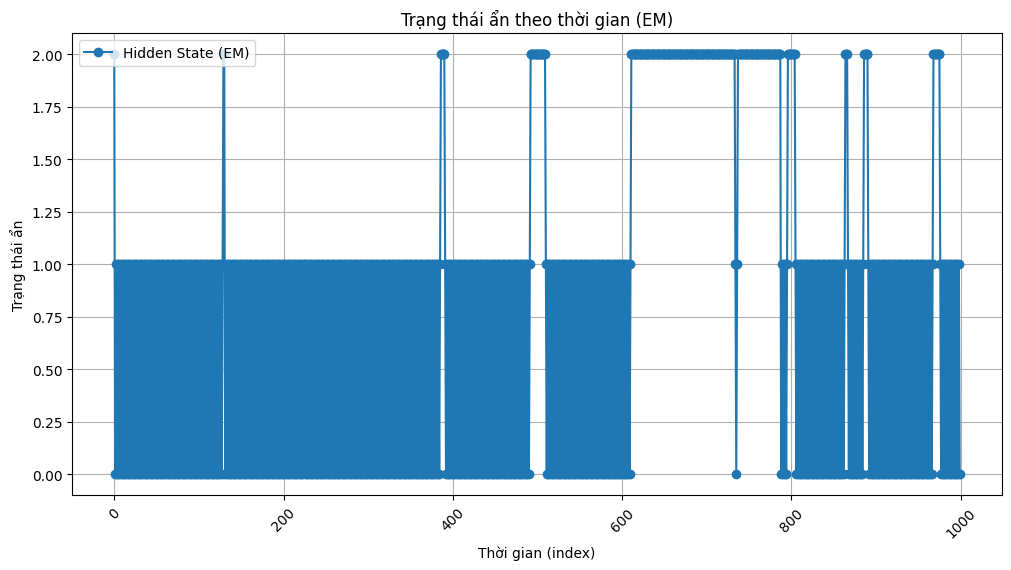

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data.index[:1000], data['Hidden_State_EM'][:1000], label='Hidden State (EM)', marker='o')
plt.xlabel('Thời gian (index)')
plt.ylabel('Trạng thái ẩn')
plt.title('Trạng thái ẩn theo thời gian (EM)')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Trực quan hóa so sánh log-likelihood

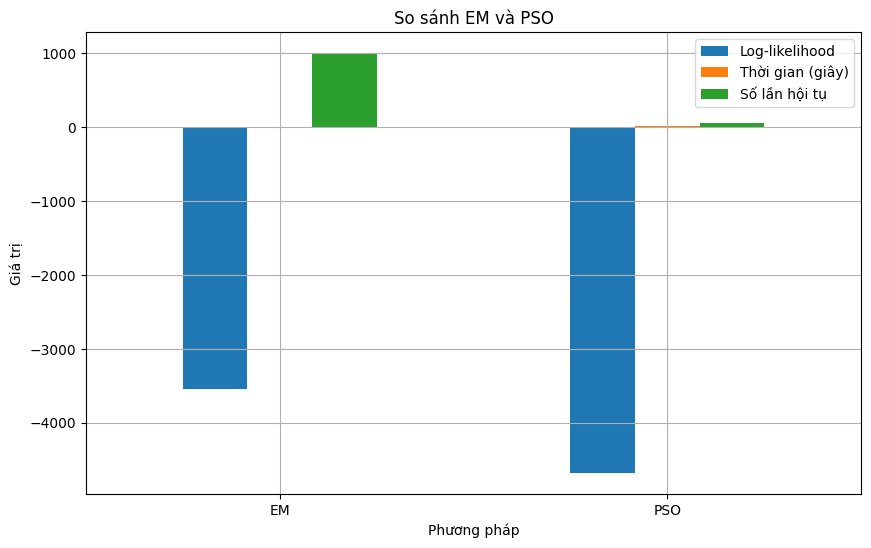


Bảng so sánh chi tiết:
  Phương pháp  Log-likelihood  Thời gian (giây)  Số lần hội tụ
0          EM    -3546.253826          2.912609           1000
1         PSO    -4681.657513          9.544819             50


In [ ]:
comparison_data = {
    'Phương pháp': ['EM', 'PSO'],
    'Log-likelihood': [log_likelihood_em, log_likelihood_pso],
    'Thời gian (giây)': [time_em, time_pso],
    'Số lần hội tụ': [1000, num_iterations]  # EM dùng n_iter=1000, PSO dùng số lần lặp thực tế
}
df_comparison = pd.DataFrame(comparison_data)

plt.figure(figsize=(10, 6))
df_comparison.plot(x='Phương pháp', y=['Log-likelihood', 'Thời gian (giây)', 'Số lần hội tụ'], kind='bar', ax=plt.gca())
plt.title('So sánh EM và PSO')
plt.ylabel('Giá trị')
plt.xticks(rotation=0)
plt.legend(loc='best')
plt.grid()
plt.show()

print("\nBảng so sánh chi tiết:")
print(df_comparison)